In [1]:
%matplotlib ipympl

import numpy as np
from matplotlib import pyplot as plt
import hj_reachability as hj
import hj_reachability.shapes as shp
import pyspect as ps

In [2]:
class Set(ps.Set):

    vf: np.ndarray
    grid: hj.Grid
    timeline: np.ndarray
    dynamics: hj.Dynamics

    solver_settings = hj.SolverSettings.with_accuracy("low")
    
    def __init__(self, dynamics, grid, timeline, vf, **kwargs):
        super().__init__(**kwargs)

        self.dynamics = dynamics
        self.timeline = timeline
        self.grid = grid
        self.vf = vf

    def copy(self):
        return Set(self.dynamics, 
                   self.grid, 
                   self.timeline.copy(), 
                   self.vf.copy(), 
                   approx=self.approx)
    
    @classmethod
    def empty(self):
        return np.ones(self.grid.shape)
    
    def is_empty(self):
        return np.all(0 < self.vf)
    
    def membership(self, point):
        idx = self.grid.nearest_index(point)
        return self.vf[idx] <= 0
    
    def complement(self):
        s = super().complement()
        s.vf = np.asarray(-s.vf)
        return s
    
    def union(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().union(other)
        s.vf = np.asarray(np.minimum(self.vf, other.vf))
        return s
    
    def intersect(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().intersect(other)
        s.vf = np.asarray(np.maximum(self.vf, other.vf))
        return s
    
    def reach(self, constraints=None):
        s = super().reach(constraints)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      self.vf,
                      constraints if constraints is None else constraints.vf)
        s.vf = np.asarray(vf)
        return s

    def rci(self):
        s = super().rci()
        s._make_tube()
        target = np.ones_like(s.vf)
        target[-1, ...] = s.vf[-1, ...]
        constraint = s.vf
        vf = hj.solver(self.solver_settings,
                       self.dynamics,
                       self.grid,
                       self.timeline,
                       target,
                       constraint)
        s.vf = np.asarray(np.flip(vf, axis=0))
        return s

    def _is_invariant(self):
        return len(self.vf.shape) != len(self.timeline.shape + self.grid.shape)

    def _make_tube(self):
        if self._is_invariant():    
            self.vf = np.concatenate([self.vf[np.newaxis, ...]] * len(self.timeline))


In [3]:

BACKGROUND = plt.imread('Eskilstuna-Intersection.png')

min_bounds = np.array([0.0, 0.0, -np.pi, -np.pi/5, +0])
max_bounds = np.array([6.0, 4.5, +np.pi, +np.pi/5, +1])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (61, 46, 31, 7, 11),
                                                               periodic_dims=2)
print('dx =', grid.spacings[0], 'dy =', grid.spacings[1])


2024-03-07 21:36:02.133162: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


dx = 0.10000001 dy = 0.1


In [ ]:

def plot_set(ax, vf, **kwargs):
    vf = shp.project_onto(vf, 0, 1) # project non-shared states to the shared states
    vf = np.where(vf <= 0, 0.5, np.nan)            
    vf = vf.T # imshow flips axis
    return [ax.imshow(vf, vmin=0, vmax=1, origin='lower', **kwargs)]

def plot_map(*pairs):
    plt.figure
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9*4/3, 9))
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_ylabel("y [m]")
    ax.set_xlabel("x [m]")
    ax.invert_yaxis()
    ax.imshow(BACKGROUND, extent=extent)
    for cmap, vf in pairs:
        plot_set(ax, vf, alpha=0.9, cmap=plt.get_cmap(cmap), extent=extent)
    fig.tight_layout()
    return fig

intersection = shp.intersection(shp.rectangle(grid, target_min=[3.15, 0.91], target_max=[5.15, 2.28]),
                                shp.hyperplane(grid, normal=[-1, 1],    offset=[3.4, 2.0]),
                                shp.hyperplane(grid, normal=[1, 1],     offset=[4.8, 2.0]))
print('Created intersection')
kyrkogatan_right = shp.union(intersection,
                             shp.rectangle(grid, target_min=[0,   0.91, +np.pi/2 - np.pi/5],    target_max=[4, 1.38, +np.pi/2 + np.pi/5]),
                             shp.rectangle(grid, target_min=[4.5, 0.91, +np.pi/2 - np.pi/5],    target_max=[6, 1.3,  +np.pi/2 + np.pi/5]))
print('Created kyrkogatan_right')
kyrkogatan_left = shp.union(intersection,
                            shp.rectangle(grid, target_min=[0,   1.4,  -np.pi/2 - np.pi/5], target_max=[4, 1.78, -np.pi/2 + np.pi/5]),
                            shp.rectangle(grid, target_min=[4.5, 1.31, -np.pi/2 - np.pi/5], target_max=[6, 1.68, -np.pi/2 + np.pi/5]))
print('Created kyrkogatan_left')
nygatan_up = shp.union(intersection,
                       shp.rectangle(grid, target_min=[4.2, 1.7, +np.pi - np.pi/5], target_max=[4.6, 4.5, -np.pi + np.pi/5]),
                       shp.rectangle(grid, target_min=[4.0, 0.0, +np.pi - np.pi/5], target_max=[4.3, 1.2, -np.pi + np.pi/5]))
print('Created nygatan_up')
nygatan_down = shp.union(intersection,
                         shp.rectangle(grid, target_min=[3.7, 1.7, -np.pi/5], target_max=[4.15, 4.5, +np.pi/5]),
                         shp.rectangle(grid, target_min=[3.8, 0.0, -np.pi/5], target_max=[4.1,  1.2, +np.pi/5]))
print('Created nygatan_down')
parking_lot = shp.union(shp.rectangle(grid, target_min=[1.1, 2.05], target_max=[1.5, 4.5]),
                        shp.rectangle(grid, target_min=[1.1, 2.45], target_max=[3.3, 2.8]),
                        shp.rectangle(grid, target_min=[3.05, 2.5], target_max=[3.45, 4.1]),
                        shp.rectangle(grid, target_min=[1.1, 3.65], target_max=[3.45, 4.1]),
                        shp.rectangle(grid, target_min=[1.125, 1.6], target_max=[1.45, 2.25]))
print('Created parking_lot')
parking_spot_entry_1 = shp.rectangle(grid, target_min=[1.5, 4.0], target_max=[1.9, 4.3])
parking_spot_entry_2 = shp.rectangle(grid, target_min=[2.25, 3.5], target_max=[2.7, 3.8])
parking_spot_1 = shp.rectangle(grid, target_min=[1.60, 4.15, +np.pi/2 - np.pi/5], target_max=[1.8, 4.5, +np.pi/2 + np.pi/5])
parking_spot_2 = shp.rectangle(grid, target_min=[2.35, 3.25, -np.pi/2 - np.pi/5], target_max=[2.6, 3.6, -np.pi/2 + np.pi/5])
print('Created parking_spots')
exit_zone = shp.rectangle(grid, target_min=[4.25, 4.1], target_max=[4.6, 4.45])
entry_zone = shp.rectangle(grid, target_min=[0.05, 1.4], target_max=[0.4, 1.75])
print('Created entry_zone and exit_zone')

In [4]:
def new_timeline(target_time, start_time=0, time_step=0.2):
    assert time_step > 0
    is_forward = target_time >= start_time
    target_time += 1e-5 if is_forward else -1e-5
    time_step *= 1 if is_forward else -1
    return np.arange(start_time, target_time, time_step)

timeline = new_timeline(15)

reach_dynamics = hj.systems.Bicycle5D(min_steer=-np.pi, 
                                      max_steer=+np.pi,
                                      min_accel=-0.5,
                                      max_accel=+0.5).with_mode('reach')


r1 = ps.Until(p1=..., p2=...)

out = r1(p1=Set(reach_dynamics, grid, timeline, shp.make_tube(timeline, 
                                                              shp.union(nygatan_up, kyrkogatan_right))), 
            p2=Set(reach_dynamics, grid, timeline, shp.make_tube(timeline, exit_zone)))


100%|##########| 15.0000/15.0 [00:25<00:00,  1.70s/sim_s] 


In [ ]:
# entry at kyrkogatan from the left
plot_map(
    ('Blues', shp.project_onto(out['...'].vf, 1, 2)),
).show()

In [33]:
from ipywidgets import interact, IntSlider
from functools import partial

def plot_arrow(ax: plt.Axes, pt, a, **kwargs):
    arrow_length = 0.25
    x1, y1 = pt
    x2 = arrow_length*np.cos(a) * 4/3
    y2 = arrow_length*np.sin(a)
    xbound = lambda x: max(grid.coordinate_vectors[0][0],
                           min(grid.coordinate_vectors[0][-1],
                               x))
    ybound = lambda y: max(grid.coordinate_vectors[1][0],
                           min(grid.coordinate_vectors[1][-1],
                               y))
    x1, x2 = map(xbound, [x1, x2])
    y1, y2 = map(ybound, [y1, y2])
    return [ax.arrow(x1, y1, x2, y2, **kwargs)]

def plot_set(ax: plt.Axes, vf, **kwargs):
    vf = np.where(vf <= 0, 0.5, np.nan)            
    vf = vf.T # imshow flips axis
    return [ax.imshow(vf, vmin=0, vmax=1, origin='lower', **kwargs)]

def interact_scenario(times, *pairs):
    fig, ax = plt.figure(), plt.gca()
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.axis('off')
    ax.invert_yaxis()
    interaction = partial(interact, 
                          yaw_idx=IntSlider(0, min=0, max=grid.shape[2]-1),
                          vel_idx=IntSlider(0, min=0, max=grid.shape[4]-1),
                          time_idx=IntSlider(0, min=0, max=len(times)-1))
    def render_frame(yaw_idx, vel_idx, time_idx):
        print('yaw:', grid.coordinate_vectors[2][yaw_idx] * 180/np.pi)
        print('vel:', grid.coordinate_vectors[4][vel_idx])
        ax.clear()
        ax.imshow(BACKGROUND, extent=extent)
        for cmap, vf in pairs:
            cmap = plt.get_cmap(cmap)
            vf = vf[time_idx, :, :, yaw_idx, :, vel_idx]
            vf = shp.project_onto(vf, 0, 1)
            plot_set(ax, vf, alpha=0.9, cmap=cmap, extent=extent)
            ix, iy = np.unravel_index(vf.argmin(), vf.shape)
            x = grid.coordinate_vectors[0][ix]
            y = grid.coordinate_vectors[1][iy]
            a = grid.coordinate_vectors[2][yaw_idx]
            if vf[ix, iy] <= 0:
                plot_arrow(ax, (x, y), a, color=cmap(0.75))
        fig.tight_layout()
        return fig
    return interaction, render_frame

interactive(children=(IntSlider(value=0, description='yaw_idx', max=30), IntSlider(value=0, description='vel_i…

<function __main__.interact_scenario.<locals>.render_frame(yaw_idx, vel_idx, time_idx)>

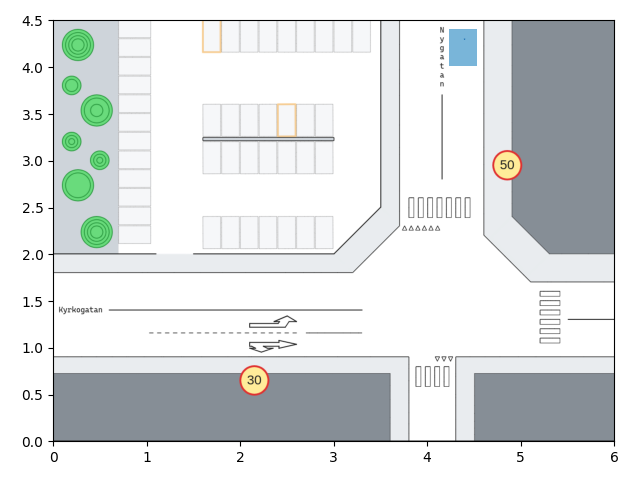

In [34]:
I, F = interact_scenario(
    timeline,
    # ('Reds',    v1_pass4),
    ('Blues',   out['...'].vf),
    # ('Blues',   shp.setminus(shp.project_onto(v2_pass1, 0, 1, 2, keepdims=True),
    #                          shp.project_onto(v1_pass1-AVOID_MARGIN, 0, 1, 2, keepdims=True))),
    # ('Purples', v3_pass4),
)
I(F)

In [ ]:
m = intersection.data.nbytes / 1024 / 1024
print(f'Intersection size: {m:.2f} MB')